In [73]:
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
import pickle

warnings.filterwarnings("ignore")

%matplotlib inline

In [84]:
data = pd.read_csv('filtered_movieData(9800).csv',encoding = "ISO-8859-1")

In [85]:
vectorizer = {'tfidf':TfidfVectorizer()}
##term frequency - inverse document frequency 
classifier = {'ClassifierCV':CalibratedClassifierCV(), 
              'logistic_regression': LogisticRegression()
             }

genres = data.Genres.value_counts().reset_index()['index']

In [86]:
max_num = len(data.Overview)
for i in range(max_num):
        if type(data.Overview[i]) == float:
            data.Overview[i] = "none"

In [87]:
n_vec = len(vectorizer)
n_clf = len(classifier)

n_iter = n_vec * n_clf

In [88]:
for genre in genres[:9]:
    data['genre_y'] = [1 if y == genre else 0 for y in data['Genres']]
    k = 1
    for vect_name, vect in vectorizer.items():
        for clf_name, clf in classifier.items():
#           print(genre.upper() + ' [' + str(k) + '/' +str(n_iter) + ']: ' + vect_name + ' - ' + clf_name )
            kf = KFold(n_splits=5, random_state=None, shuffle=False)
            pipe = Pipeline([('vect', vect), ('clf', clf)])
            
            acc = []
            prec = []
            rec = []
            f1 = []
            for train_index, test_index in kf.split(data):        
                x_train, y_train = data.Overview.iloc[train_index], data.genre_y.iloc[train_index]
                x_test, y_test = data.Overview.iloc[test_index], data.genre_y.iloc[test_index]
                pipe.fit(x_train, y_train)
                y_pred = pipe.predict(x_test)
                acc.append(np.mean(y_pred==y_test))
                prec.append(precision_score(y_test, y_pred))
                rec.append(recall_score(y_test, y_pred))
                f1.append(f1_score(y_test, y_pred))
            k+=1


In [89]:
n_vec = len(vectorizer)
n_clf = len(classifier)

n_iterations = n_vec*n_clf

temp = data.copy()

test_result = {}

for genre in genres[:9]:
    temp['genre_y'] = [1 if y == genre else 0 for y in temp['Genres']]
    k = 1
    final_score = {}
    for vect_name, vect in vectorizer.items():
        for clf_name, clf in classifier.items():
            kf = KFold(n_splits=3, random_state=None, shuffle=False)
            
            acc_normal = []
            prec_normal = []
            rec_normal = []
            f1_normal = []
            auc_normal = []
            
            acc_over = []
            prec_over = []
            rec_over = []
            f1_over = []
            auc_over = []
            
            acc_under = []
            prec_under = []
            rec_under = []
            f1_under = []
            auc_under = []
            
            i = 1
            x, y = temp.Overview, temp.genre_y
            for train_index, test_index in kf.split(data):
                x_train, y_train = x.iloc[train_index], y.iloc[train_index]
                x_test, y_test = x.iloc[test_index], y.iloc[test_index]
                
                train_vect = vect.fit_transform(x_train)
                
                clf.fit(train_vect, y_train)
                
                test_vect = vect.transform(x_test)
                y_pred = clf.predict(test_vect)

                acc_normal.append(np.mean(y_pred==y_test))
                prec_normal.append(precision_score(y_test, y_pred))
                rec_normal.append(recall_score(y_test, y_pred))
                f1_normal.append(f1_score(y_test, y_pred))
                auc_normal.append(roc_auc_score(y_test, y_pred))

                
                train_vect_over, y_train_over = SMOTE().fit_resample(train_vect, y_train) 
                clf.fit(train_vect_over, y_train_over)
                
                test_vect = vect.transform(x_test)
                y_pred = clf.predict(test_vect)

                acc_over.append(np.mean(y_pred==y_test))
                prec_over.append(precision_score(y_test, y_pred))
                rec_over.append(recall_score(y_test, y_pred))
                f1_over.append(f1_score(y_test, y_pred))
                auc_over.append(roc_auc_score(y_test, y_pred))
                #print('Overfitting: iteration ' + str(i) + ': ')
                
                train_vect_under, y_train_under = EditedNearestNeighbours().fit_resample(train_vect, y_train) 
                clf.fit(train_vect_under, y_train_under)
                
                test_vect = vect.transform(x_test)
                y_pred = clf.predict(test_vect)

                acc_under.append(np.mean(y_pred==y_test))
                prec_under.append(precision_score(y_test, y_pred))
                rec_under.append(recall_score(y_test, y_pred))
                f1_under.append(f1_score(y_test, y_pred))
                auc_under.append(roc_auc_score(y_test, y_pred))
                i+=1
            k+=1
            final_score[(vect_name, clf_name, 'over')] = np.mean(auc_over)
            final_score[(vect_name, clf_name, 'normal')] = np.mean(auc_normal)
            final_score[(vect_name, clf_name, 'under')] = np.mean(auc_under)
    test_result[genre] = max(final_score, key=final_score.get)
    print(genre , test_result[genre])

Action ('tfidf', 'ClassifierCV', 'under')
Drama ('tfidf', 'ClassifierCV', 'under')
Comedy ('tfidf', 'logistic_regression', 'over')
Horror ('tfidf', 'logistic_regression', 'over')
Animation ('tfidf', 'logistic_regression', 'over')
Adventure ('tfidf', 'ClassifierCV', 'under')
Thriller ('tfidf', 'logistic_regression', 'over')
Crime ('tfidf', 'logistic_regression', 'over')
Science Fiction ('tfidf', 'logistic_regression', 'over')


In [90]:
pipe_dict = {}
for genre in genres[:9]:
    data['genre_y'] = [1 if y == genre else 0 for y in data['Genres']]
    vect_name = test_result[genre][0]
    clf_name = test_result[genre][1]
    sampling_name = test_result[genre][2]

    vect = clone(vectorizer[vect_name])
    clf = clone(classifier[clf_name])
    
    x_vect = vect.fit_transform(data.Overview)
    
    if sampling_name == 'normal':
        clf.fit(x_vect, data.genre_y)
    elif sampling_name == 'over':
        x_vect, y = SMOTE().fit_resample(x_vect, data.genre_y)
        clf.fit(x_vect, y)
    elif sampling_name == 'under':
        x_vect, y = EditedNearestNeighbours().fit_resample(x_vect, data.genre_y)
        clf.fit(x_vect, y)
    pipe_dict[genre] = Pipeline([('vect', vect), ('clf', clf)])

In [91]:
def predict_genre(s, pipe_dict):
    genre_analyzed = []
    proba = []
    for genre, pipe in list(pipe_dict.items()):
        print(genre, pipe)
        res = pipe.predict_proba([s])
        genre_analyzed.append(genre)
        print(genre)
        proba.append(res[0][1])
        
    data = pd.DataFrame({'genre': genre_analyzed, 'proba': proba})
    index = data.index
    index.name = "9600 datas"
    data = data.sort_values(by='proba', ascending=True)
    ax = data.plot(x='genre', y='proba', kind='barh')
    print(genre_analyzed, proba)
    plt.show()

Action Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', CalibratedClassifierCV())])
Action
Drama Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', CalibratedClassifierCV())])
Drama
Comedy Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', LogisticRegression())])
Comedy
Horror Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', LogisticRegression())])
Horror
Animation Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', LogisticRegression())])
Animation
Adventure Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', CalibratedClassifierCV())])
Adventure
Thriller Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', LogisticRegression())])
Thriller
Crime Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', LogisticRegression())])
Crime
Science Fiction Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', LogisticRegression())])
Science Fiction
['Action', 'Drama', 'Comedy', 'Horror', 'Animation', 'Adventure', 'Thriller', 'Crime', 'Science Fiction'] [0.036872410232040825, 0.02209649

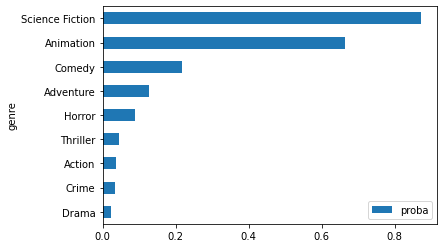

In [92]:
predict_genre("machine", pipe_dict)

In [93]:
with open("trained_data2.txt","wb") as fw:
    pickle.dump(pipe_dict,fw)